In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from truco_env import TrucoMineiroEnv

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import base64
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

def display_video(frames):
    orig_backend = matplotlib.get_backend()
    matplotlib.use('Agg')
    fig, ax = plt.subplots(1, 1, figsize=(6, 5))
    matplotlib.use(orig_backend)
    ax.set_axis_off()
    ax.set_aspect('equal')
    ax.set_position([0, 0, 1, 1])
    im = ax.imshow(frames[0])
    def update(frame):
        im.set_data(frame)
        return [im]
    anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                   interval=100, blit=True, repeat=False)

    gif_path = "animation.gif"
    anim.save(gif_path, writer='pillow', fps=1)

    with open(gif_path, 'rb') as f:
        gif_data = f.read()
    gif_base64 = base64.b64encode(gif_data).decode('ascii')

    return HTML(f'<img src="data:image/gif;base64,{gif_base64}">')

# Sarsa

In [ ]:
"""
state: [c1, c2, c3] -> cards in the agents hand
        c4 -> card in the table
        w -> who won the first round
compress the state as single integer ->
suppose that instead of 3 cards, it represents 3 coordinates in 3d space,
we can ravel it as a integer, helping a bit with coding
considering:
4p -> 0; 7c -> 1; Ae -> 2; 7o -> 3; 3 -> 4; 2 -> 5; A -> 6 ...
4 -> 13
w is -1 if agent lost first round, 0 if draw/undecided, 1 if won

action: c -> card to be played
c = 0, 1 or 2, corresponding to the index of the card to be played

i will be considering that env.step returns a done variable, that is True
when the episode is over

TODO:
adopt convention: always sort the list of player cards, to avoid
repeating states !! ex: [11, 10, 3] is the same as [3, 11, 10]
also, leaving 0 always at the end of the list is required, and helps a lot
Fazer bater com o ambiente, rodar quantidade alta de episodios, analisar grafico/winrate
"""

class SarsaAgent:
    def __init__(self, eps: float, alpha: float, gamma: float, env) -> None:
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.state_action_shape = (14, 14, 14, 14, 3, 3)
        # dictionary to store Q values
        self.Q = {}

    def _convert_state_action(self, state: list[int], action: int) -> int:
        state.sort(reverse=True)
        state_action = [idx for idx in state]
        state_action.append(action)
        state_action[4] += 1 # converts the -1 to 0, so that we can use it here
        return np.ravel_multi_index(state_action, self.state_action_shape)

    def _choose_greedy_action(self, state: list[int]) -> int:
        action = 0
        # add possible action if the card isnt 0, and it is the first 3 cards in the list
        possible_actions = [i for i, idx in enumerate(state) if idx != 0 and i < 3]
        # perform exploration
        if np.random.uniform(0, 1) < self.eps:
            return np.random.choice(possible_actions)
        # perfom exploitation
        else:
            Q_values = []
            for action in possible_actions:
                compressed = self._convert_state_action(state, action)
                # get the Q value, or return 0 if it doesnt have value yet
                Q_values.append(self.Q.get(compressed, 0))
            return np.argmax(Q_values)

    def run(self, n_episodes: int) -> None:
        reward = 0
        for _ in range(n_episodes):
            # obtain starting states and action
            state_1 = self.env.reset()
            action_1 = self._choose_greedy_action(state_1)
            # loops through the episode
            while True:
                # get next state, reward and next action
                state_2, reward, done = self.env.step(action_1)
                action_2 = self._choose_greedy_action(state_2)

                sa1_compressed = self._convert_state_action(state_1, action_1)
                sa2_compressed = self._convert_state_action(state_2, action_2)

                q1 = self.Q.get(sa1_compressed, 0)
                q2 = self.Q.get(sa2_compressed, 0)
                # updates the Q value
                self.Q[sa1_compressed] = q1 + self.alpha * (reward + self.gamma*q2 - q1)

                state_1 = state_2
                action_1 = action_2

                if done:
                    break

In [ ]:
agent = SarsaAgent(0.1, 1)
agent._convert_state_action([11, 10, 2, 4, -1], 0)
agent.Q[289584] = 3
select_action = [agent._choose_greedy_action([11, 10, 2, 4, -1]) for _ in range(10)]
select_action

# Q-Learning

In [3]:
class QLearningAgent:
    def __init__(self, eps, alpha, gamma, env):
        self.eps = eps
        self.alpha = alpha
        self.gamma = gamma
        self.env = env
        self.Q_values = {}

    def _format_state(self, state):
        return (state[0], tuple(state[1]), state[2])

    def _choose_greedy_action(self, state):
        if np.random.uniform(0, 1) < self.eps:
            action = np.random.choice(range(len(self.Q_values[state])))
        else:
            action = np.argmax(self.Q_values[state])
        return action

    def _add_state(self, state):
        if state not in self.Q_values.keys():
            self.Q_values[state] = [0 for a in [0, 1, 2] if state[1][a] != 0]

    def _max_terminal(self, state):
        if state[1] == (0, 0, 0):
            return 0
        else:
            return max(self.Q_values[state])

    def run(self, num_episodes):
        stats = {'wins': 0, 'winrate': []}
        for episode in tqdm(range(1, num_episodes + 1)):
            state = self.env.reset(reset_score=True)['observation']
            state = self._format_state(state)
            self._add_state(state)
            while True:
                action = self._choose_greedy_action(state)
                response = self.env.step(action)
                next_state, reward, done = response['observation'], response['reward'], response['done']
                next_state = self._format_state(next_state)
                self._add_state(next_state)
                self.Q_values[state][action] += self.alpha * (reward + self.gamma * self._max_terminal(state) - self.Q_values[state][action])
                state = next_state
                if done:
                    if reward == 1:
                        stats['wins'] += 1
                    if episode % 100 == 0:
                        stats['winrate'].append(stats['wins']/episode)
                    break
                if state[1] == (0, 0, 0):
                    state = self.env.reset(reset_score=False)['observation']
                    state = self._format_state(state)
                    self._add_state(state)
        return stats

    def _append_frame(self, frames, factor):
        for _ in range(factor):
            frames.append(self.env.render(render_mode="rgb_array"))
        return frames

    def test_agent(self, episodes=1, factor=1):
        if not isinstance(factor, int) or factor < 1:
            raise ValueError("Factor must be an integer greater than 0.")

        frames = []
        for _ in range(episodes):
            state = self._format_state(self.env.reset()["observation"])
            frames = self._append_frame(frames, factor)

            while True:
                action = self._choose_greedy_action(state)
                response = self.env.step(action)
                next_state, reward, done = response['observation'], response['reward'], response['done']
                state= self._format_state(next_state)
                if state[1] == (0, 0, 0):
                    state = self._format_state(self.env.reset(reset_score=False)["observation"])

                if not done:
                    frames = self._append_frame(frames, factor)
                else:
                    break

        return display_video(frames)

In [4]:
env = TrucoMineiroEnv()
qlearning = QLearningAgent(0.1, 0.1, 0.99, env)
num_episodes = 1_000_000
stats_qlearning = qlearning.run(num_episodes)

100%|██████████| 1000000/1000000 [53:43<00:00, 310.21it/s] 


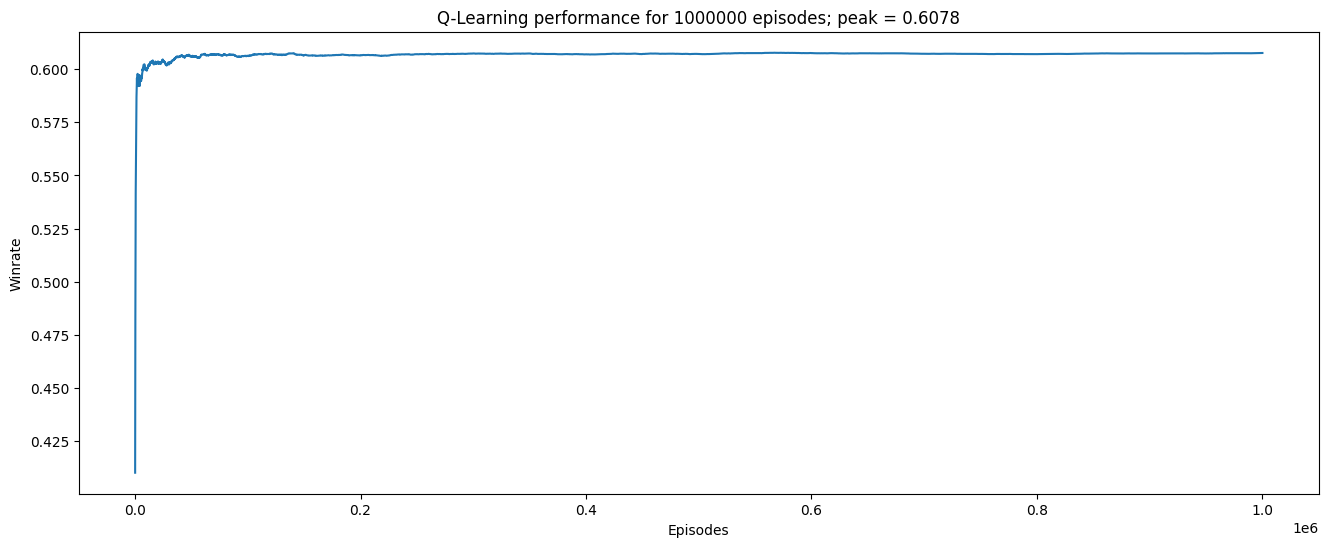

In [5]:
x = [i * 100 for i in range(1, num_episodes//100 + 1)]
y = stats_qlearning["winrate"]

plt.figure(figsize=(16, 6))
plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"Q-Learning performance for {num_episodes} episodes; peak = {max(y):.4f}")
plt.show()

In [ ]:
stats_qlearning['winrate'][-1]

In [ ]:
qlearning.Q_values


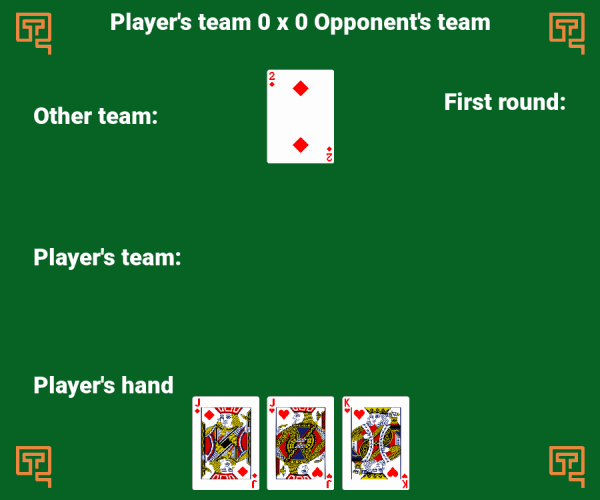

In [6]:
qlearning.test_agent(episodes=1, factor=4)

# MonteCarlo

In [7]:
"""
TODO: Adicionar comentários
"""

from typing import Union

class MonteCarloAgent:
    def __init__(self, epsilon: float, gamma: float, env, on_policy: bool = True) -> None:
        self.epsilon = epsilon
        self.gamma = gamma
        self.env = env
        self.on_policy = on_policy
        self.total_actions = env.action_space.n
        self.action_values = {}
        self.stats = {}

    def _convert_state_format(self, state: tuple[int, list[int, int, int], int]) -> tuple[int, int, int, int, int]:
        return (state[0],) + tuple(state[1].tolist()) + (state[2],)

    def _add_state_action_pair(self, state: tuple[int, int, int, int, int], action: int) -> None:
        if (state, action) not in self.action_values.keys():
            self.action_values[(state, action)] = 0

    def _choose_action(self, state: tuple[int, int, int, int, int], explore: bool) -> int:
        possible_actions = [idx-1 for idx in range(1,4) if state[idx] != 0]
        if explore and np.random.random() < self.epsilon:
            return np.random.choice(possible_actions)
        max_value = float('-inf')
        for action in possible_actions:
            if (state, action) not in self.action_values.keys():
                self.action_values[(state, action)] = 0
            if self.action_values[(state, action)] > max_value:
                max_value = self.action_values[(state, action)]
                greedy_actions = [action]
            elif self.action_values[(state, action)] == max_value:
                greedy_actions.append(action)
        return np.random.choice(greedy_actions)

    def _generate_episode(self) -> list[list[Union[tuple[int, int], int, int]]]:
        episode_transitions = []
        done = False
        state = self._convert_state_format(self.env.reset()["observation"])
        while not done:
            action = self._choose_action(state, explore = True)
            response = self.env.step(action)
            next_state, reward, done = response["observation"], response["reward"], response["done"]
            mc_reward = 0 if not done else self.env.score[1] - self.env.score[0]
            episode_transitions.append([state, action, mc_reward]) # S_n A_n R_{n+1}
            if np.all(next_state[1] == 0):
                state = self._convert_state_format(self.env.reset(reset_score=False)["observation"])
            else:
                state = self._convert_state_format(next_state)
        return episode_transitions

    def _store_winrate(self, episode_n: int, episode_transitions: list[list[Union[tuple[int, int], int, int]]]) -> None:
        if "wins" not in self.stats:
            self.stats["wins"] = 0
        if "winrate" not in self.stats:
            self.stats["winrate"] = []
        self.stats["matches"] = episode_n
        if episode_transitions[-1][-1] > 0:
            self.stats["wins"] += 1
        if episode_n % 1_000 == 0:
            self.stats["winrate"].append(self.stats["wins"]/self.stats["matches"])

    def _on_policy_mc(self, episodes: int) -> None:
        returns = {}
        for episode_n in tqdm(range(1,episodes+1)):
            episode_transitions = self._generate_episode()
            self._store_winrate(episode_n, episode_transitions)
            G = 0
            for t in range(len(episode_transitions) - 1, -1, -1):
                state, action, reward = episode_transitions[t]
                G = reward + self.gamma * G
                if (state, action) not in returns:
                    returns[(state, action)] = [0, 0]
                old_mean, n = returns[(state, action)]
                returns[(state, action)] = [old_mean + (G - old_mean) / (n+1), n + 1]
                self.action_values[(state, action)] = returns[(state,action)][0]

    def _off_policy_mc(self, episodes: int) -> None:
        csa = {}
        for episode_n in tqdm(range(1,episodes+1)):
            episode_transitions = self._generate_episode()
            self._store_winrate(episode_n, episode_transitions)
            G = 0
            W = 1
            for t in range(len(episode_transitions) - 1, -1, -1):
                state, action, reward = episode_transitions[t]
                G = reward + self.gamma * G
                if (state, action) not in csa.keys():
                    csa[(state, action)] = 0
                if (state, action) not in self.action_values.keys():
                    self.action_values[(state, action)] = 0
                csa[(state, action)] += W
                self.action_values[(state, action)] += W / csa[(state, action)] * (G - self.action_values[(state, action)])
                if action != self._choose_action(state, explore = False):
                    break
                W /= (1 - self.epsilon + self.epsilon/self.total_actions)

    def run(self, episodes: int) -> None:
        if self.on_policy:
            self._on_policy_mc(episodes)
        else:
            self._off_policy_mc(episodes)

    def _append_frame(self, frames, factor):
        for _ in range(factor):
            frames.append(self.env.render(render_mode="rgb_array"))
        return frames


    def test_agent(self, episodes=1, factor=1):
        if not isinstance(factor, int) or factor < 1:
            raise ValueError("Factor must be an integer greater than 0.")

        frames = []
        for _ in range(episodes):
            state = self._convert_state_format(self.env.reset()["observation"])
            frames = self._append_frame(frames, factor)

            while True:
                action = self._choose_action(state, explore = True)
                response = self.env.step(action)
                next_state, reward, done = response["observation"], response["reward"], response["done"]
                if np.all(next_state[1] == 0):
                    state = self._convert_state_format(self.env.reset(reset_score=False)["observation"])
                else:
                    state = self._convert_state_format(next_state)

                if not done:
                    frames = self._append_frame(frames, factor)
                else:
                    break

        return display_video(frames)

    def get_stats(self):
        return self.stats

In [8]:
episodes = 1_000_000
env = TrucoMineiroEnv()
mc_on_policy_agent = MonteCarloAgent(0.1, 0.99, env, on_policy = True)
mc_on_policy_agent.run(episodes)

100%|██████████| 1000000/1000000 [1:02:21<00:00, 267.25it/s]



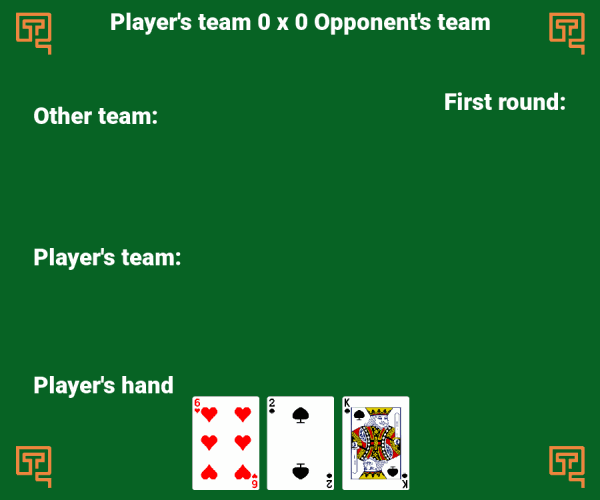

In [9]:
mc_on_policy_agent.test_agent(episodes=1, factor=4)

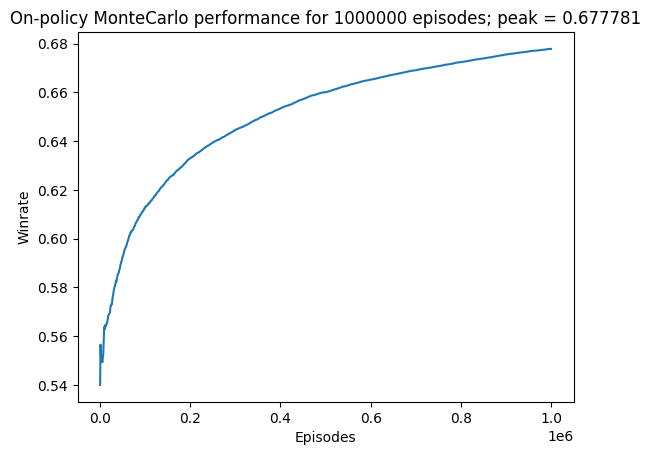

In [11]:
stats = mc_on_policy_agent.get_stats()

x = np.linspace(0, episodes, episodes//1000)
y = stats["winrate"]

%matplotlib inline
plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"On-policy MonteCarlo performance for {episodes} episodes; peak = {max(y)}")
plt.show()

In [12]:
mc_off_policy_agent = MonteCarloAgent(0.1, 0.99, env, on_policy= False)
mc_off_policy_agent.run(episodes)

100%|██████████| 1000000/1000000 [1:13:34<00:00, 226.51it/s]


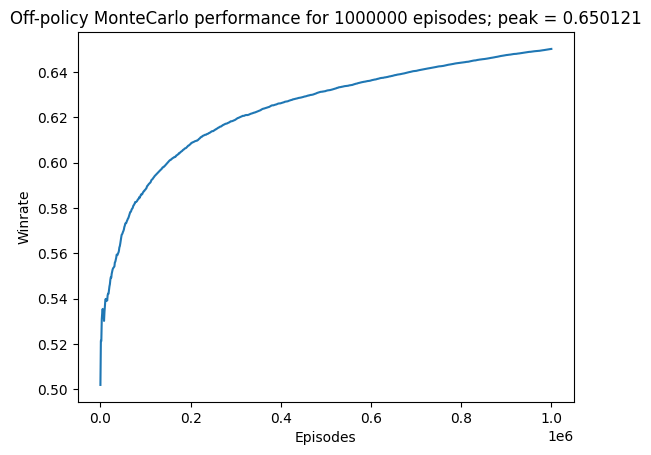

In [13]:
stats = mc_off_policy_agent.get_stats()

x = np.linspace(0, episodes, episodes//1000)
y = stats["winrate"]

%matplotlib inline
plt.plot(x, y)
plt.xlabel("Episodes")
plt.ylabel("Winrate")
plt.title(f"Off-policy MonteCarlo performance for {episodes} episodes; peak = {max(y)}")
plt.show()


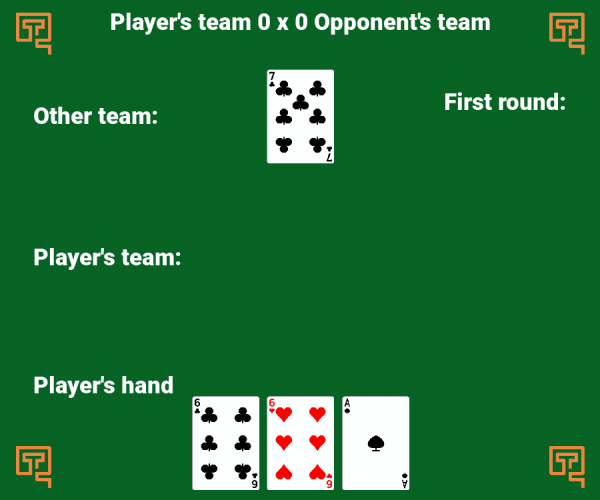

In [14]:
mc_off_policy_agent.test_agent(episodes=1, factor=4)